In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from math import *
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
# Deux fonctions (au moins) permettent de faire de l'estimation à noyau sous Python
# La première KDEUnivarite
from statsmodels.nonparametric.kde import KDEUnivariate 
from statsmodels.nonparametric.kernel_regression import KernelReg # NW et Polynome locaux p=0
import statsmodels.nonparametric.bandwidths
# La seconde KernelDensity
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
#from sklearn_extensions.kernel_regression import KernelRegression


## Validation croisée et choix de $h$

Il existe des règles de choix de $h$

In [3]:
n = 500
grid = np.linspace(0,1,500)
X = st.beta.rvs(2,2, size = n)
true_f =st.beta.pdf(grid,2,2)


h1 = statsmodels.nonparametric.bandwidths.bw_scott(X)
h2 = statsmodels.nonparametric.bandwidths.bw_silverman(X)

(1.06*np.sqrt(np.var(X))*n**(-1/5), h1, h2)

(0.06892160342459366, 0.06892554308436626, 0.05857694879691183)

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity 
bandwidths = 10 ** np.linspace(-2, 1, 100)
GG = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv= 2)
GG.fit(X.reshape(-1,1)) # On reshape car X n'a qu'une seule dimension et le fit espère deux dimensions
h_cv = GG.best_params_["bandwidth"] 
h_cv

GridSearchCV(cv=2, estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.01      ,  0.01072267,  0.01149757,  0.01232847,  0.01321941,
        0.01417474,  0.01519911,  0.01629751,  0.01747528,  0.01873817,
        0.02009233,  0.02154435,  0.0231013 ,  0.02477076,  0.02656088,
        0.02848036,  0.03053856,  0.03274549,  0.03511192,  0.03764936,
        0.04037017,  0.04328761,  0.04641589,  0.04977024,  0.05336699,
        0.05722...
        0.93260335,  1.        ,  1.07226722,  1.149757  ,  1.23284674,
        1.32194115,  1.41747416,  1.51991108,  1.62975083,  1.7475284 ,
        1.87381742,  2.009233  ,  2.15443469,  2.3101297 ,  2.47707636,
        2.65608778,  2.84803587,  3.05385551,  3.27454916,  3.51119173,
        3.76493581,  4.03701726,  4.32876128,  4.64158883,  4.97702356,
        5.33669923,  5.72236766,  6.13590727,  6.57933225,  7.05480231,
        7.56463328,  8.11130831,  8.69749003,  9.32603347, 10.        ])})

0.03511191734215131

Text(0.5, 0, 'X')

Text(0, 0.5, 'fonction densité')

Text(0.5, 1.0, 'Représentation de la densité')

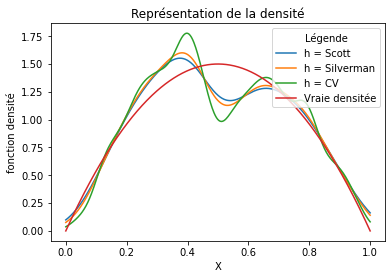

In [5]:
# Utilisation en densité
def f_hat(grid , X, h, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels""" 
    # grid: grille de points où l'estimateur de $f$ sera évalué
    # X: échantillon (X_1,..., X_n)
    # h: choix de la taille de la fenêtre
    # **kwargs: arguments optionels Par défaut le noyau gaussien est utilisé
    kde = KDEUnivariate(X)
    kde.fit(bw = h, **kwargs)
    return kde.evaluate(grid)


g1, = plt.plot(grid, f_hat(grid, X, h1))
g2, = plt.plot(grid, f_hat(grid, X, h2))
g3, = plt.plot(grid, f_hat(grid, X, h_cv))
g4, = plt.plot(grid, true_f)

plt.legend([g1, g2, g3, g4], ['h = Scott', 'h = Silverman', 'h = CV', 'Vraie densitée'],
              loc = 'upper right' , title = 'Légende')
plt.xlabel('X')
plt.ylabel('fonction densité')
plt.title('Représentation de la densité')



In [6]:
# Utilisation en régression
n = 1000
sg = sqrt(1)
X = 2*np.pi*np.random.beta(1, 3, n) # accumulations de points en certains endroits de l'intervalle de définition
eps = np.random.normal(0,sg, n) # autre loi?
def r(x): return(3/(x+1)+5+4*np.cos(x))
Y = r(X)+eps


h1 = statsmodels.nonparametric.bandwidths.bw_scott(X)
h2 = statsmodels.nonparametric.bandwidths.bw_silverman(X)

(1.06*np.sqrt(np.var(X))*n**(-1/5), h1, h2)

# Validation croisée avec la fonction KernelReg
grid = np.linspace(0, 2*np.pi, 100)
Kreg = KernelReg(Y, X, var_type = 'c' , reg_type = 'll', bw = 'cv_ls') 
h_cv = Kreg.bw
h_cv

(0.3259092071435751, 0.32576466870270987, 0.27685382609295456)

array([0.20560288])

In [7]:
Kreg1 = KernelReg(Y, X, var_type = 'c' , reg_type = 'll', bw = h1*np.ones(1)) 
r_hat1, dr_hat1 = Kreg1.fit(grid)
Kreg2 = KernelReg(Y, X, var_type = 'c' , reg_type = 'll', bw = h2*np.ones(1)) 
r_hat2, dr_hat2 = Kreg2.fit(grid)

Text(0.5, 0, 'X')

Text(0, 0.5, 'fonction de régressioń')

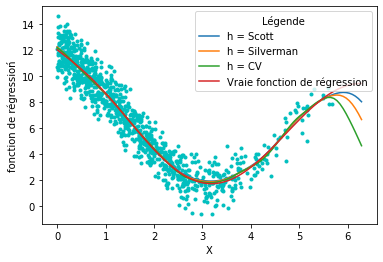

In [8]:
g, =  plt.plot(X,Y, 'c.')
g1, = plt.plot(grid, r_hat1)
g2, = plt.plot(grid, r_hat2)
g3, = plt.plot(grid, Kreg.fit(grid)[0])
g4, = plt.plot(grid, r(grid))

plt.legend([g1, g2, g3, g4], ['h = Scott', 'h = Silverman', 'h = CV', 'Vraie fonction de régression'],
              loc = 'upper right' , title = 'Légende')
plt.xlabel('X')
plt.ylabel('fonction de régressioń')


## Estimation de la variance de l'erreur

Dans cette section  on se place dans le cadre du cours $Y_i=r(X_i)+\varepsilon_i$, où on sait estimer la fonction de régression $r$. On cherche maintennat à avoir une idée de l'importance de l'erreur que l'on fait quand on approche $Y_i\approx \hat r_{\hat h}(X_i)$. Pour cela (par exemple pour construire un intervalle de confiance dur la valeur de $\hat r_{\hat h}(x_0)$ estimée on doit pouvoir évaluer $\mathbb V(\varepsilon_1) = \mathbb E(\varepsilon_1^2)=\sigma^2.$

On va voir ici, comment estimer la variance de l'erreur (cadre *homoscedastique*).

**Idée de l'estimateur:** Comme pour la régression linéaire, on aimerait estimer $\sigma^2$ par l'estimateur classique de la variance $$\frac{1}{n-1}\sum_{i=1}^n\varepsilon_i^2,$$ mais *on n'observe pas une seule réaslisation de $\varepsilon_i$* donc on ne peut pas utiliser cette estimateur. On contourne le problème (comme pour les MCO) en utilisant des **estimateurs** de $\varepsilon_i$: $$\hat \varepsilon_i=Y_i-\hat r_{\hat h}(X_i)$$. On obtient l'estimateur suivant $$\hat \sigma^2 = \frac{1}{n-1}\sum_{i=1}^n(\hat\varepsilon_i)^2.$$

*Question: Pourquoi divise-t-on par $(n-1)$?*

In [9]:
n = 5000
sg = sqrt(2.7)
#X = np.random.uniform(0, 2*np.pi, n)# nombre égal de points sur tout l'intervalle de définition
X = 2*np.pi*np.random.beta(1, 3, n) # accumulations de points en certains endroits de l'intervalle de définition
eps = np.random.normal(0,sg, n) # autre loi?
def r(x): return(3/(x+1)+5+4*np.cos(x))
def dr(x): return(-3/(x+1)**2-4*np.sin(x)) # dérivée de r
# def r(x): return(np.cos(x))
# def dr(x): return(-np.sin(x))
Y = r(X)+eps

In [10]:
kr =KernelReg(Y, X, var_type = 'c' , reg_type = 'll', bw = 'cv_ls')
r_est, dr_est0 = kr.fit(X)
hat_sigma2 = 1/(n-1)*sum((Y-r_est)**2)
print(f"l'estimateur de la variance est {hat_sigma2}"  )

l'estimateur de la variance est 2.6963498391142924


## Monte Carlo: estimation de l'erreur (ponctuelle) quadratique moyenne

**QUAND ON CONNAIT LA FONCTION DE REGRESSION $r$ QUE L'ON ESTIME ET QUE l'ON SAIT GENERER DES ECHANTILLONS INDEPENDANTS DE $(Y,X)$"**, (c'est-à-dire jamais en pratique) on peut évaluer le risque de l'estimateur par méthode dite de Monte-Carlo (qui permet d'estimer des espérances: en s'appuyant sur la même idée que les sommes de Riemann). La procédure est la suivante:

On approche $\mathbb E[(\hat r_{\hat h}(x_0)-r(x_0))^2]$ par 
$$\frac{1}{M}\sum_{m=1}^M(\hat r^{(m)}_{\hat h}(x_0)-r(x_0))^2$$ où $M$ est grand (au moins de l'ordre de $\sqrt{n}$) et $\hat r^{(m)}_{\hat h}(x_0)$, $1\le m\le M$ sont évalués sur $M$  échantillons indépendants.

*Pourquoi?*

In [11]:
def MC(x0, n, r, Xlaw, elaw, M = ceil(sqrt(n))):
    MC = np.nan*np.ones(M)

    for m in range(M):
        X = Xlaw.rvs(n)
        eps = elaw.rvs(n)
        Y = r(X) + eps
        h = statsmodels.nonparametric.bandwidths.bw_scott(X) # Trop long de faire de la valisation croisée
        kr = KernelReg(Y, X, var_type = 'c' , reg_type = 'll', bw = h*np.ones(1))
        r_est, dr_est = kr.fit(x0)
        MC[m] = np.mean((r_est-r(x0))**2) # au cas où x0 soit un grille dans ce cas c'est le risque quadratique intégré qui est 
        # renvoyé
    hat_risk = np.mean(MC)
    
    print(f"Le risque de l'estimateur de $r$ au point {x0} est {hat_risk}")
    

(array([254., 199., 157., 131., 111.,  60.,  43.,  27.,  13.,   5.]),
 array([9.17048465e-05, 9.22540793e-02, 1.84416454e-01, 2.76578828e-01,
        3.68741203e-01, 4.60903577e-01, 5.53065952e-01, 6.45228326e-01,
        7.37390701e-01, 8.29553075e-01, 9.21715449e-01]),
 <BarContainer object of 10 artists>)

Le risque de l'estimateur de $r$ au point [0.8] est 0.0597337978548367


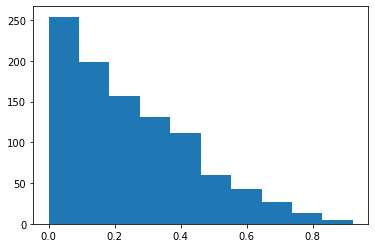

In [12]:
n = 1000
sg = sqrt(1)
# Regarder des points x0 différents et comparer selon la loi de X, qu'attend-on et que remarque-t-on?

# Xlaw = st.uniform(0, pi) 
Xlaw = st.beta(1, 3)
plt.hist(Xlaw.rvs(n))
elaw = st.norm(0,sg)
x0 = np.array([0.8])
def r(x): return(3/(x+1)+5+4*np.cos(x))
# def r(x): return(np.cos(x))
MC(x0, n, r, Xlaw, elaw)

## Estimation dans le modèle mutiplicatif

Supposons que les données ne proviennent pas d'un modèle additif $Y_i=r(X_i)+\varepsilon_i$, mais d'un modèle multiplicatif:
 $Y_i=r(X_i)\varepsilon_i$ avec $\mathbb E[\varepsilon_i]=1$ et $\mathbb V(\varepsilon_i)= \sigma^2$.
 
 On cherche donc à estimer la fonction $r$ qui est l'espérance de $Y$. *Ce modèle est-il homoscedastique?*
 
 On va mettre en comparaison deux méthodes:
 - **SI ON SUPPOSE $r>0$ et $\varepsilon >0 $** (*Pourquoi? le signe serait-il identifiable sinon?*): On passe au Logarithme pour revenir à un modèle linéaire comme étudié en cours :
 $$\log(Y_i) = \log(r(X_i)) + \varepsilon_i,$$ estimer la fonction $\log(r)$ avec l'estimateur du cours et en prendre l'exponentielle pour estimer $r$.
 - On utilise le fait que $\mathbb E[Y_i]= r(X_i),$ pour estimer $r$ on peut faire un Nadaraya-Watson (*Pourquoi?*).

(1.5010035683209935, 0.4077598537416081)

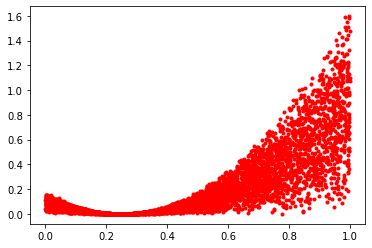

In [13]:
n = 5000
sg = sqrt(2)
X = st.uniform.rvs(0, 1, n)
eps = st.uniform.rvs(0,2, n) +  st.uniform.rvs(0,1, n) # autre loi?
(np.mean(eps), np.var(eps))
def r(x): return((x-1/4)**2)
Y = r(X)*eps

plt.plot(X, Y, 'r.')
grid = np.linspace(0, 1, 100)

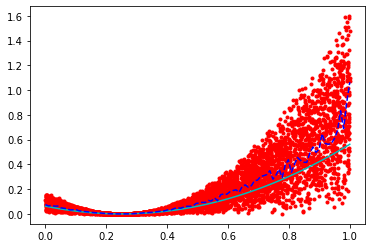

In [14]:
# Méthode 1
kr = KernelReg(np.log(Y), X, var_type = 'c' , reg_type = 'll', bw = 'cv_ls')
r_est, dr_est = kr.fit(grid)
r_hat = np.exp(r_est)

plt.plot(X, Y, 'r.')
plt.plot(grid, r(grid), 'c-')
plt.plot(grid, r_hat, 'b--')

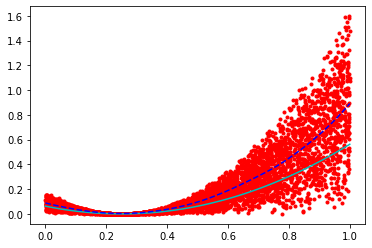

In [15]:
# Méthode 2: faire un NW
kr = KernelReg(Y, X, var_type = 'c' , reg_type = 'll', bw = 'cv_ls')
r_hat, dr_est = kr.fit(grid)


plt.plot(X, Y, 'r.')
plt.plot(grid, r(grid), 'c-')
plt.plot(grid, r_hat, 'b--')

## Exemple de données réelles

In [16]:
#import pandas
#data = pandas.read_csv("Documents/COURS PV/Dauphine RNP/mammals.csv",sep = ',',header = 0,index_col = 0)
#data
#np.mean(data.body)

In [17]:
#plt.plot(data.body,data.brain,'r.')

#s = 5000 # 500, 100, 50, 5
#X = data.body[data.body < s]
#Y = data.brain[data.body < s]
#(np.min(data.body),np.max(data.body))
#(np.min(X),np.max(X))

#plt.plot(X,Y,'c.')

LinearRegression(normalize=True)

(array([0.76136109]), -0.16237644159836812)

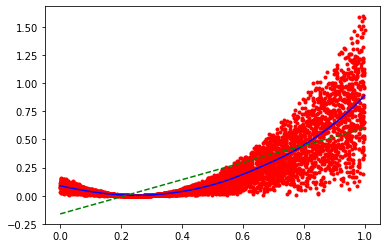

In [18]:
plt.plot(X,Y,'r.')

grid = np.linspace(np.min(X),np.max(X), 100)
kr = KernelReg(Y, X, var_type = 'c' , reg_type = 'll', bw = 'cv_ls')
r_est, dr_est = kr.fit(grid)


plt.plot(grid, r_est, 'b')


# Comparaison avec la régression linéaire
from sklearn.linear_model import LinearRegression 
reg = LinearRegression(normalize=True)
reg.fit(np.array(X).reshape(-1,1),np.array(Y).reshape(-1,1))


a = reg.coef_[0]
b = reg.intercept_[0]
(a,b)
plt.plot(grid, a* grid+b, 'g--')